In [1]:
from Model.Energy import GeneralizedGaussianMixtureEnergy
from Model.Proposal import GaussianProposal
from Data import get_dataloader_from_data
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from Model.Trainer import SNLTrainer
from Model.Energy import MaxMinTruncation

/opt/miniconda3/envs/lime_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Training data 

/var/folders/j8/dm7qjtj55w3f6yvlj6rd2vx40000gn/T/ipykernel_39347/4135321491.py:4: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525849783/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1626.)
  cholesky_1 = torch.cholesky(variance_matrix_1)


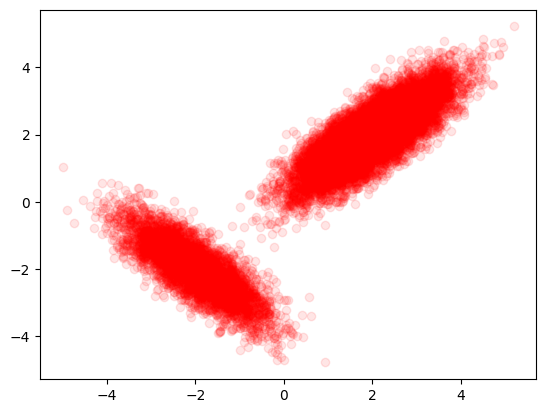

In [2]:

variance_matrix_1 = torch.tensor([[1.0, 0.5], [0.5, 1.0]])
# project matrix to symetric positive definite matrix
variance_matrix_1 = (variance_matrix_1 @ variance_matrix_1.t())/2
cholesky_1 = torch.cholesky(variance_matrix_1)

variance_matrix_2 = torch.tensor([[1.0, -0.5], [-0.5, 1.0]])
# project matrix to symetric positive definite matrix
variance_matrix_2 = (variance_matrix_2 @ variance_matrix_2.t())/2
cholesky_2 = torch.cholesky(variance_matrix_2)





data_1 = torch.distributions.MultivariateNormal(torch.tensor([2.0, 2.0]), scale_tril=cholesky_1).sample((15000,))
data_2 = torch.distributions.MultivariateNormal(torch.tensor([-2.0, -2.0]), scale_tril=cholesky_2).sample((5000,))
data = torch.cat((data_1, data_2), dim=0)

plt.scatter(data[...,0].numpy(), data[...,1].numpy(), color='r', alpha=0.1) 

In [3]:


dataset_total = TensorDataset(data, )
data_train, data_val, data_test = torch.utils.data.random_split(dataset_total, [10000, 5000, 5000])
dataloader_train = DataLoader(data_train, batch_size=100, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=100, shuffle=False)

# Proposal

In [4]:
proposal_distribution = GaussianProposal(torch.Size([2,]), torch.tensor([0,0], dtype=torch.float32), torch.tensor([10,10], dtype=torch.float32))

Init Standard Gaussian...


/var/folders/j8/dm7qjtj55w3f6yvlj6rd2vx40000gn/T/ipykernel_39347/2233292355.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525849783/work/torch/csrc/utils/tensor_new.cpp:233.)
  input_grid = torch.tensor([X,Y], dtype=torch.float32).permute(1,2,0)


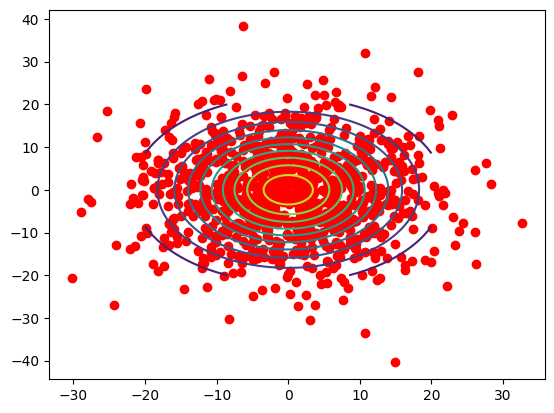

In [5]:
sample_proposal = proposal_distribution.sample(1000,)

fig = plt.figure()
ax = fig.add_subplot(111)
# Add gaussian distribution as contours

x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(x, y)
input_grid = torch.tensor([X,Y], dtype=torch.float32).permute(1,2,0)
Z = proposal_distribution.log_prob(input_grid.flatten(0,1)).exp().numpy().reshape(X.shape)
ax.contour(X, Y, Z, levels=10)


# Add points
ax.scatter(sample_proposal[...,0], sample_proposal[...,1], color='r')

# Energy

In [6]:
energy = GeneralizedGaussianMixtureEnergy(dim=2, num_cluster=2, learn_mu=True, learn_sigma=True)
# energy.set_truncator(MaxMinTruncation(min = torch.tensor([-1,-20], dtype=torch.float32), max= torch.tensor([20,20], dtype=torch.float32)))

In [7]:
print(data.shape)
energy.energy(data)

torch.Size([20000, 2])


/Users/hhjs/Documents/Projects/SNL_directional/Model/Energy/gaussian_mixture.py:245: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.log_softmax(self.logit_pi) - energy_per_cluster, dim=-1


tensor([ 4.6623,  5.3618,  5.8719,  ...,  4.7934, 11.3578,  2.6340],
       grad_fn=<NegBackward0>)

# Trainer :


In [8]:
trainer = SNLTrainer(energy=energy, proposal=proposal_distribution, dataloader=dataloader_train, val_dataloader=dataloader_val , n_sample_train=1000, n_sample_test=1000, lr=0.01, )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hugosenetaire. Use `wandb login --relogin` to force relogin


In [ ]:
trainer.train(n_iter=200_000, n_iter_pretrain=1000,)

/Users/hhjs/Documents/Projects/SNL_directional/Model/Energy/gaussian_mixture.py:245: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.log_softmax(self.logit_pi) - energy_per_cluster, dim=-1
